In [137]:
import pandas as pd
import geopandas as gpd
import numpy as np
import urllib.parse
import re
from geodatasets import get_path
import matplotlib.pyplot as plt

In [138]:
#url = u"https://vi.wikipedia.org/wiki/Danh_sách_nhà_máy_điện_Mặt_Trời_ở_Việt_Nam"
#ascii_url = urllib.parse.quote(url, safe=':/')
#tables = pd.read_html(ascii_url, encoding='utf-8')
#tables[0].to_csv('./raw/wiki_list.csv', compression=None)

In [139]:
df = pd.read_csv("./raw/wiki_list.csv", index_col=0)
df = df.drop(0)
df.columns = ['name', 'mw', 'production_kwh_year', 'cons_start', 'op_start', 'coords', 'adm_loc', 'region_loc']
def fix_coords(c_str):
    try:
        t_str = c_str.split(sep="/")[1].replace(" \ufeff", "").split(sep=" ")
        t_str = [float(re.sub(r"°[A-Za-zĐ]", "", t).replace(",", ".")) for t in t_str]
        return t_str
    except AttributeError:
        return [np.nan, np.nan]

df['lon'] = df['coords'].apply(lambda x: fix_coords(x)[0])
df['lat'] = df['coords'].apply(lambda x: fix_coords(x)[1])
df['region_loc'] = df['region_loc'].apply(lambda x: re.sub(r" \[\d+\]", "", x))
df['adm_loc'] = df['adm_loc'].apply(lambda x: x[x.find("huyện ")+len("huyện "):] if isinstance(x, str) else np.nan)
df = df.drop(columns='coords', axis=1)
df = df.dropna(subset=['lon'])
df.tail(10)

,name,mw,production_kwh_year,cons_start,op_start,adm_loc,region_loc,lon,lat
130,Hồ Gia Hoét 1,35.0,NaN,11/2019,8/2020,Châu Đức,Bà Rịa Vũng Tàu,10.70183,107.28892
131,Hồ Tầm Bó,35.0,NaN,11/2019,8/2020,Châu Đức,Bà Rịa Vũng Tàu,10.69919,107.26618
132,KCN Châu Đức,70.0,NaN,7/2018,2019,Châu Đức,Bà Rịa Vũng Tàu,10.57919,107.18127
133,Bình Hòa,10.0,NaN,3/2018,6/2019,Châu Thành,An Giang,10.45697,105.34115
134,Sao Mai Solar PV1,210.0,302.0,6/2018,7/2019,Tịnh Biên,An Giang,10.47612,105.01042
135,Văn Giáo 1,50.0,69.0,8/2018,6/2019,Tịnh Biên,An Giang,10.46995,105.01314
136,Văn Giáo 2,50.0,69.0,8/2018,6/2019,Tịnh Biên,An Giang,10.46995,105.01314
138,Hậu Giang,29.0,NaN,6/2020,12/2020,Phụng Hiệp,Hậu Giang,9.75956,105.61870
139,Trung Nam Trà Vinh,165.0,250.0,1/2019,12/2019,Duyên Hải,Trà Vinh,9.59876,106.52573
140,Cà Mau,50.0,739.0,2018,6/2019,Ngọc Hiển,Cà Mau,8.61143,105.01517


In [140]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['lat'], df['lon']), crs="EPSG:4326"
)
gdf.tail()

,name,mw,production_kwh_year,cons_start,op_start,adm_loc,region_loc,lon,lat,geometry
135,Văn Giáo 1,50.0,69.0,8/2018,6/2019,Tịnh Biên,An Giang,10.46995,105.01314,POINT (105.01314 10.46995)
136,Văn Giáo 2,50.0,69.0,8/2018,6/2019,Tịnh Biên,An Giang,10.46995,105.01314,POINT (105.01314 10.46995)
138,Hậu Giang,29.0,NaN,6/2020,12/2020,Phụng Hiệp,Hậu Giang,9.75956,105.61870,POINT (105.6187 9.75956)
139,Trung Nam Trà Vinh,165.0,250.0,1/2019,12/2019,Duyên Hải,Trà Vinh,9.59876,106.52573,POINT (106.52573 9.59876)
140,Cà Mau,50.0,739.0,2018,6/2019,Ngọc Hiển,Cà Mau,8.61143,105.01517,POINT (105.01517 8.61143)


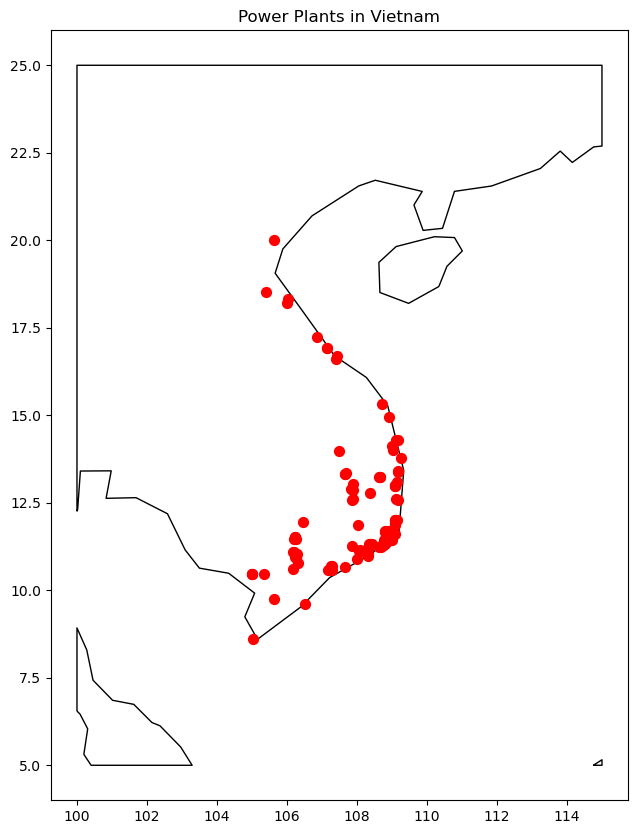

In [141]:
world = gpd.read_file(get_path("naturalearth.land"))
vietnam = world.clip([100, 5, 115, 25])
# Clip the Vietnam map to the region of interest

# Plot the map and the points
fig, ax = plt.subplots(figsize=(10, 10))
vietnam.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=50, label="Power Plants", aspect=1)

# Add labels for the points
#for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.name):
#    ax.text(x, y, label, fontsize=8, ha='right', va='bottom')

plt.title("Power Plants in Vietnam")
#plt.legend()
plt.show()

In [147]:
group = df.groupby(by="region_loc")
for k, v in group:
    print(k, v['mw'].sum())
#dfs = [df for _, df in group]


An Giang 440.0
Bà Rịa Vũng Tàu 9597.0
Bình Phước 88245.0
Bình Thuận 31054.0
Bình Định 235.0
Cà Mau 739.0
Gia Lai 206.0
Hà Tĩnh 0.0
Hậu Giang 0.0
Khánh Hòa 553.0
Kon Tum 724.0
Long An 60.0
Ninh Thuận 10026.0
Phú Yên 486.0
Quảng Bình 6581.0
Quảng Ngãi 772.0
Quảng Trị 1948.0
Thanh Hóa 0.0
Thừa Thiên - Huế 616.0
Thừa Thiên Huế 68.0
Trà Vinh 250.0
Tây Ninh 1092.0
Đăk Lăk 1739.0
Đăk Nông 1027.0
